# Ellipse Cloud Persistent Homology Analysis

In [1]:
import numpy
import matplotlib.pyplot as plt

import ellphi

In [2]:
%matplotlib inline

In [3]:
rng = numpy.random.default_rng(seed=7777)
alpha = 0.8
delta = 1.2
num_points = 210
near = 7
eps = 0.3

## Construct synthetic dataset and local covariance matrices

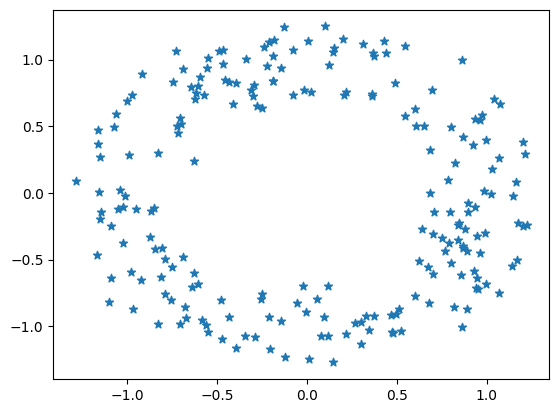

In [4]:
theta = rng.uniform(0, 2 * numpy.pi, num_points)
noise = rng.uniform(-eps, eps, size=(2, num_points))
data = ellphi.unit_vector(theta) + noise
plt.scatter(data[0], data[1], marker='*')

## Mahalanobis distance associated with a covariance matrix $S$
For a covariance matrix $S$, we can define the Mahalanobis distance
$$ d_S^\mathrm{M}(x, x') = \sqrt{(x - x')^\top S^{-1} (x - x')}. $$
Then, the contour $d_S^\mathrm{M}(x, x_0) = r$ forms an ellipse. Note that $S$ is positive semi-definite. By eigendecomposition of $S$, we get $S = U D U^\top$, where $U$ is an orthogonal matrix. The level set equation reads as
$$
(x - x_0)^\top U^\top D^{-1} U (x - x_0) = r^2.
$$
Thus, we obtain the level set equation of the norm form as
$$
\|D^{-1/2} U (x - x_0)\|^2 = r^2.
$$
The unit vector $\zeta = r^{-1} D^{-1/2} U (x - x_0)$ can be parametrized by $\zeta = (\cos t, \sin t)^\top$, from which we obtain the parametrization of the ellipse,
$$
x = x_0 + r U^\top D^{1/2} \zeta.
$$

In [5]:
def ellipse_curve_cov(x0=0, y0=0, cov=[[1,0],[0,1]], scale=1, N=100):
    """
    Input
    =====
    (x0, y0) : center point
    cov : covariance matrix
    N : number of parameters
    
    Output
    ======
    {'x': x, 'y': y} : dict
        The parametrization of the given ellipse
    """
    D, U = numpy.linalg.eig(cov)
    sqrtD = numpy.diag(numpy.sqrt(D))
    t = numpy.linspace(0, 2 * numpy.pi, N)
    c = numpy.transpose([[x0, y0]])
    x, y = U @ (scale * sqrtD @ ellphi.unit_vector(t)) + c
    return {'x': x, 'y': y}

def ellipse_patch(x0, y0, r1=1, r2=1, theta=0, *, cov=None, scale=1):
    if cov is not None:
        r1, r2, theta = ellphi.axes_from_cov(cov)
    ellipse = plt.matplotlib.patches.Ellipse(
        (x0, y0),
        width=2*r1*scale,
        height=2*r2*scale,
        angle=numpy.degrees(theta),
        edgecolor='black',
        facecolor='none',
        linestyle='-'
    )
    return ellipse

We generate a random point cloud.

In [6]:
theta = rng.uniform(0, 2 * numpy.pi, num_points)
noise = rng.uniform(-eps, eps, size=(2, num_points))
noise[0, :num_points//3] -= delta
noise[0, -num_points//3:] += delta
noise[1, num_points//3:] += delta
noise[1, -num_points//3:] -= delta
data = ellphi.unit_vector(theta) + noise
data[1] *= alpha

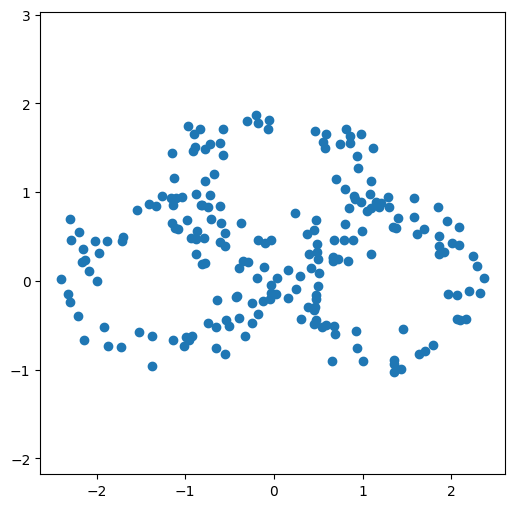

In [7]:
fig, ax = plt.subplots(1, 1, figsize=(6, 6))
ax.scatter(*data, marker='o')
ax.set_aspect('equal', adjustable='datalim')
plt.show()

In [8]:
# Euclidean distance matrix
d = numpy.linalg.norm(data[:, None, :] - data[:, :, None], axis=0)
# Construct k-neighbourhood
nbd_subsets = numpy.unique(numpy.argsort(d, axis=1)[:, :near], axis=0)
sorted_subsets = [tuple(sorted(subset)) # each subset as a sorted tuple
                  for subset in nbd_subsets]
# Remove duplicated subsets
unique_subsets = numpy.unique(sorted_subsets, axis=0)

# Each row consists of the indices of k-nbd
nbd_subsets.shape, unique_subsets.shape

((210, 7), (173, 7))

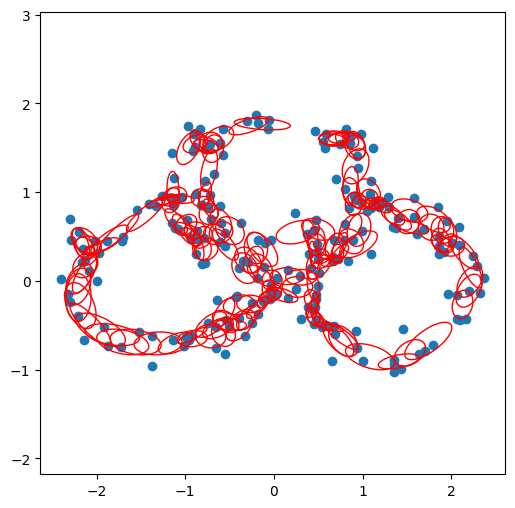

In [9]:
fig, ax = plt.subplots(1, 1, figsize=(6, 6))
ax.scatter(*data, marker='o')
ax.set_aspect('equal', adjustable='datalim')

# Construct and plot ellipses from local covariance matrices of k-nbd
ellipses = []
for near_indices in unique_subsets:
    near_data = data[:, near_indices]
    mean, cov = numpy.mean(near_data, axis=1), numpy.cov(near_data)
    e = ellphi.coef_from_cov(*mean, cov)
    ellipses.append((e, mean, cov))
    p = ellipse_patch(*mean, cov=cov)
    p.set(edgecolor='red')
    ax.add_patch(p)

## Tangency solver `ellphi.tangency`

Suppose the ellipses increase in proportion to time. The function `ellphi.tangency(ellipse1, ellipse2)` solves the tangency problem where the both input ellipses, `ellipse1` and `ellipse2`, are expanding. The result `TangencyResult` contains the first time of tangency `t`, the `point` of tangency, and the associated Lagrange multiplier `mu` solving the minimization problem.

In [10]:
ellphi.tangency(ellipses[1][0], ellipses[2][0])

TangencyResult(t=0.17437616684361937, point=array([-2.20021828, -0.23540216]), mu=0.4794286441968935)

## Construct Ellipse Cloud

Now, we construct an ellipse cloud using `ellphi.tangency`.

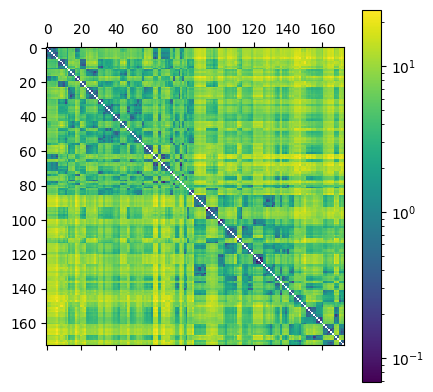

In [11]:
from itertools import combinations

num_objs = len(ellipses)
dist = numpy.zeros((num_objs, num_objs))
colliders = {}
for (i0, e0), (i1, e1) in combinations(enumerate(ellipses), 2):
    colliders[i0, i1] = colliders[i1, i0] = ellphi.tangency(e0[0], e1[0])
    dist[i0, i1] = dist[i1, i0] = colliders[i0, i1][0]

plt.matshow(dist, norm='log')
plt.colorbar()

## Pipeline to HomCloud

We can construct a Vietoris-Rips (VR) filtration from a quasi-distance matrix `dist`, and compute the persistent homology. The computation of VR filtrations is supported in most modern TDA libraries such as HomCloud, Gudhi, giotto-tda, ripser, and so on.

Here, for example, we use [HomCloud](https://homcloud.dev/) so that we can visualize the optimal 1-cycles (generators), the very useful inverse-analysis feature provided by HomCloud.

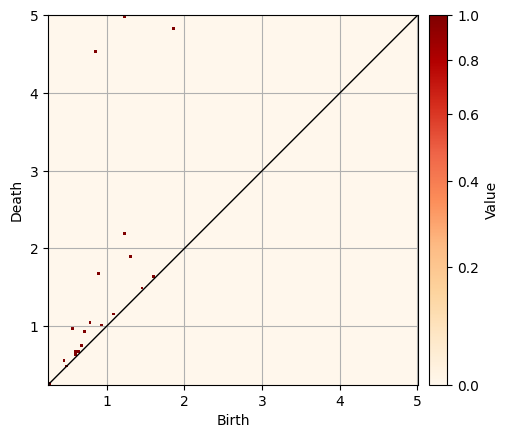

In [12]:
import homcloud.interface as hc

hc.PDList.from_rips_filtration(dist, maxdim=2, save_to="rips.pdgm", save_graph=True)
pdlist = hc.PDList("rips.pdgm")
pd1 = pdlist.dth_diagram(1)
pd1.histogram().plot(colorbar={"type": "loglog"})
plt.show()

Let's examine the generator of some birth-death pair. A so-called optimal 1-cycle can be computed by HomCloud's function [`optimal_1_cycle`](
https://homcloud.dev/python-api/interface.html#homcloud.interface.Pair.optimal_1_cycle).

In [13]:
bd = max(pd1.pairs(), key=lambda p: p.death_time())
optimal_1_cycle = bd.optimal_1_cycle()
bd, optimal_1_cycle.boundary_points()

(Pair(1.2191855907440186, 5.003762722015381),
 [148,
  149,
  160,
  157,
  155,
  153,
  81,
  134,
  105,
  115,
  90,
  89,
  130,
  162,
  170,
  144,
  145])

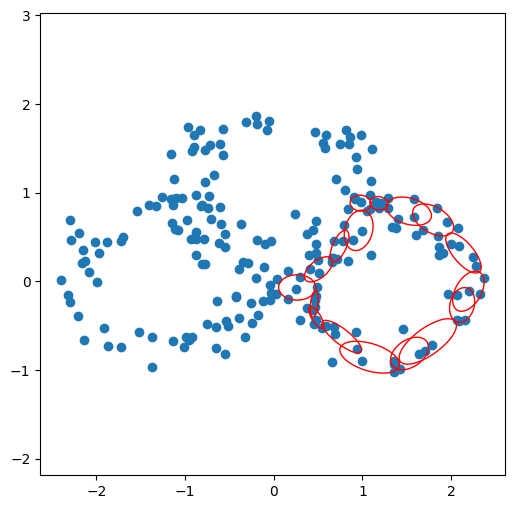

In [14]:
fig, ax = plt.subplots(1, 1, figsize=(6, 6))
ax.scatter(*data, marker='o')
ax.set_aspect('equal', adjustable='datalim')

for generator in optimal_1_cycle.boundary_points():
    near_indices = unique_subsets[generator]
    near_data = data[:, near_indices]
    mean, cov = ellipses[generator][1:]
    p = ellipse_patch(*mean, cov=cov, scale=bd.birth_time())
    p.set(edgecolor='red')
    ax.add_patch(p)